In [2]:
import os
import yaml
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

from datetime import datetime
from pathlib import Path
from matplotlib.patches import Rectangle

BASE_DIR = Path(os.path.abspath('')).parent.parent
os.chdir(BASE_DIR)
print(f'Working directory: {os.getcwd()}')

from utils import *

Working directory: c:\Users\Jesper\Documents\GitHub Local\ARFusion


In [3]:
with open('config_MM.yaml' ,'r') as file:
    config = yaml.safe_load(file)

ds_NCBI = pd.read_pickle(config['data']['NCBI']['load_path'])
ds_TESSy = pd.read_pickle(config['data']['TESSy']['load_path'])

# Experiment with systematic removal of genes

### Genes in the multimodal dataset

In [4]:
ds_MM = ds_NCBI[ds_NCBI['num_ab'] > 0].copy()
df_genes = ds_MM[['genotypes', 'num_genotypes']]
df_genes['num_genotypes'].describe()

count    6468.000000
mean        6.296691
std         5.065668
min         1.000000
25%         2.000000
50%         4.000000
75%         9.000000
max        40.000000
Name: num_genotypes, dtype: float64

In [5]:
genotypes = ds_MM['genotypes']
genotypes_exploded = genotypes.explode()
gene_counts = genotypes_exploded.value_counts()
gene_counts.describe()

count     336.000000
mean      121.211310
std       444.617562
min         1.000000
25%         1.750000
50%         4.500000
75%        21.000000
max      5890.000000
Name: count, dtype: float64

In [6]:
unique_genotypes = ds_MM['genotypes'].explode().unique().tolist()
unique_genotypes

['gyrA_S83L=POINT',
 'blaTEM-1',
 'parC_S80I=POINT',
 'glpT_E448K=POINT',
 'parC_E84K=POINT',
 'pmrB_Y358N=POINT',
 'ompC_Q82STOP=POINT',
 'soxS_A12S=POINT',
 'gyrA_D87N=POINT',
 'tet(A)',
 'blaOXA-1',
 'blaCTX-M-15',
 "aac(6')-Ib-cr5",
 'parE_S458A=POINT',
 'cyaA_S352T=POINT',
 'sul1',
 'aadA1',
 'uhpT_E350Q=POINT',
 'aac(3)-VIa',
 'blaCMY-2',
 "aph(3'')-Ib",
 'parC_E84V=POINT',
 'aadA5',
 'pmrB_E123D=POINT',
 'sul2',
 'mph(A)',
 'ptsI_V25I=POINT',
 'blaCTX-M-27',
 'parE_I529L=POINT',
 'dfrA17',
 'aph(6)-Id',
 'blaOXA-181',
 'dfrA14',
 'qnrS1',
 'floR',
 "aph(3')-Ia=PARTIAL_END_OF_CONTIG",
 'fosA7.5',
 'tet(M)',
 'dfrA1',
 'parE_L416F=POINT',
 'blaCMY=PARTIAL_END_OF_CONTIG',
 'ampC_C-42T=POINT',
 'tet(B)',
 "aph(3')-Ia",
 'aac(3)-IId',
 "aph(3'')-Ib=PARTIAL_END_OF_CONTIG",
 'qnrB19',
 'sat2',
 'dfrA12',
 'aadA2',
 'sul2=PARTIAL_END_OF_CONTIG',
 'qnrB2',
 'catA1',
 'dfrA5',
 'blaTEM=PARTIAL_END_OF_CONTIG',
 'parC_S57T=POINT',
 'gyrA_D87G=POINT',
 'parC_E84A=POINT',
 "aac(6')-Ib4",
 'ca

Using **Reference Gene Catalog** from NCBI to map genotypes to antibiotic class

In [7]:
pd.set_option('display.max_rows', None)
genotype_ref = pd.read_csv('data/refgenes.tsv', sep='\t')
# genotype_ref = genotype_ref[(genotype_ref['Scope'] == 'core') & (genotype_ref['#Allele'].notna()) & (genotype_ref['Type'] == 'AMR')]
genotype_ref = genotype_ref[(genotype_ref['Scope'] == 'core') & (genotype_ref['Type'] == 'AMR')].reset_index(drop=True)
print(genotype_ref.shape[0])

8117


In [8]:
genotype_ref['Subtype'].value_counts()

Subtype
AMR                6801
POINT              1290
AMR-SUSCEPTIBLE      26
Name: count, dtype: int64

In [9]:
pm_ref = genotype_ref[genotype_ref['Subtype'] == 'POINT']
gene_ref = genotype_ref[genotype_ref['Subtype'] != 'POINT']
pm_ref.shape[0], gene_ref.shape[0], gene_ref.shape[0]

(1290, 6827, 6827)

In [10]:
genotype_ref[genotype_ref['Gene family'].str.contains("aac(3)")][['#Allele', 'Gene family']]	

C:\Users\Jesper\AppData\Local\Temp\ipykernel_21072\66229539.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  genotype_ref[genotype_ref['Gene family'].str.contains("aac(3)")][['#Allele', 'Gene family']]


,#Allele,Gene family


In [11]:
genotype_ref['Class'].value_counts()

Class
BETA-LACTAM                                                       4870
AMINOGLYCOSIDE                                                     743
QUINOLONE                                                          465
COLISTIN                                                           300
TETRACYCLINE                                                       268
GLYCOPEPTIDE                                                       234
TRIMETHOPRIM                                                       142
PHENICOL                                                           130
MACROLIDE                                                          127
RIFAMYCIN                                                          103
FOSFOMYCIN                                                          92
LINCOSAMIDE/MACROLIDE/STREPTOGRAMIN                                 80
FUSIDIC ACID                                                        69
LIPOPEPTIDE                                                         56


In [12]:
pm_to_ab_class = pm_ref.set_index('#Allele')['Class'].to_dict()
print(pm_to_ab_class.keys())
gene_to_ab_class = gene_ref.set_index('Gene family')['Class'].to_dict()
print(gene_to_ab_class.keys())
gene_allele_to_ab_class = gene_ref[gene_ref['#Allele'].notna()].set_index('#Allele')['Class'].to_dict()
print(gene_allele_to_ab_class.keys())

dict_keys(['16S_A1055G', '16S_A1408G', '16S_A1499G', '16S_A1519C', '16S_A1519G', '16S_A1519T', '16S_A523C', '16S_A794G', '16S_A794T', '16S_A964G', '16S_C1054T', '16S_C1065T', '16S_C1066T', '16S_C1191T', '16S_C1192A', '16S_C1192G', '16S_C1192T', '16S_C528T', '16S_G1053A', '16S_G1058C', '16S_G1064A', '16S_G1064C', '16S_G1064T', '16S_G1068A', '16S_G527T', '16S_G926A', '16S_G926C', '16S_G926T', '16S_T1406A', '23S_A2045G', '23S_A2057G', '23S_A2058G', '23S_A2058T', '23S_A2074C', '23S_A2074G', '23S_A2074T', '23S_A2075G', '23S_A2114G', '23S_A2115G', '23S_A2118G', '23S_A2145G', '23S_A2531G', '23S_C2220T', '23S_C2579T', '23S_C2597T', '23S_C2611T', '23S_C2627A', '23S_C2630A', '23S_C2630G', '23S_C658T', '23S_G2032A', '23S_G2032C', '23S_G2032T', '23S_G2057A', '23S_G2447T', '23S_G2475T', '23S_G2505A', '23S_G2533A', '23S_G2576T', '23S_G2577T', '23S_G2604T', '23S_G2794T', '23S_T2501A', '23S_T2528A', '23S_T2532C', '23S_T2609C', '23S_T754A', '50S_L22_A103C', '50S_L22_A103V', '50S_L22_A84D', '50S_L22_A88

In [13]:
unique_genotypes = gene_counts.index.tolist()
genotype_to_ab_class = {}
for g in unique_genotypes:
    if "aac(3)-II" in g: # aac(3)-II does not appear exactly in either the Allele or Gene family columns
                genotype_to_ab_class[g] = 'AMINOGLYCOSIDE'
    else:   
        if g.endswith('=POINT'):
            genotype_to_ab_class[g] = pm_to_ab_class[g.split('=')[0]]
        elif ('=PARTIAL' in g) or ('=HMM' in g) or ('=MISTRANSLATION' in g):
            genotype_to_ab_class[g] = gene_to_ab_class[g.split('=')[0]]
        else:
            try:
                genotype_to_ab_class[g] = gene_to_ab_class[g]
            except:
                genotype_to_ab_class[g] = gene_allele_to_ab_class[g]
print(genotype_to_ab_class)

{'glpT_E448K=POINT': 'FOSFOMYCIN', 'pmrB_E123D=POINT': 'COLISTIN', 'pmrB_Y358N=POINT': 'COLISTIN', 'blaTEM-1': 'BETA-LACTAM', 'tet(A)': 'TETRACYCLINE', 'sul2': 'SULFONAMIDE', "aph(3'')-Ib": 'AMINOGLYCOSIDE', 'uhpT_E350Q=POINT': 'FOSFOMYCIN', 'aph(6)-Id': 'AMINOGLYCOSIDE', 'gyrA_S83L=POINT': 'QUINOLONE', 'sul1': 'SULFONAMIDE', 'tet(B)': 'TETRACYCLINE', 'parC_S80I=POINT': 'QUINOLONE', 'cyaA_S352T=POINT': 'FOSMIDOMYCIN', 'gyrA_D87N=POINT': 'QUINOLONE', 'marR_S3N=POINT': 'MULTIDRUG', 'aadA1': 'AMINOGLYCOSIDE', 'mph(A)': 'MACROLIDE', 'dfrA17': 'TRIMETHOPRIM', 'ptsI_V25I=POINT': 'FOSFOMYCIN', 'aadA5': 'AMINOGLYCOSIDE', 'parE_I529L=POINT': 'QUINOLONE', 'blaCTX-M-15': 'BETA-LACTAM', 'parC_E84V=POINT': 'QUINOLONE', "aph(3')-Ia": 'AMINOGLYCOSIDE', 'aac(3)-IId': 'AMINOGLYCOSIDE', 'aadA2': 'AMINOGLYCOSIDE', 'blaCMY-2': 'BETA-LACTAM', 'aac(3)-VIa': 'AMINOGLYCOSIDE', 'blaOXA-1': 'BETA-LACTAM', 'floR': 'PHENICOL', 'dfrA1': 'TRIMETHOPRIM', "aac(6')-Ib-cr5": 'AMINOGLYCOSIDE/QUINOLONE', 'qnrS1': 'QUINOL

### Filtering out isolates containing **beta-lactam** genes

In [17]:
filter_by = ['BETA-LACTAM']
num_before = ds_MM.shape[0]
ds_MM_filtered = ds_MM[ds_MM['genotypes'].apply(
                lambda x: not any(f in genotype_to_ab_class[gene] for f in filter_by for gene in x)
            )].reset_index(drop=True)
num_after = ds_MM_filtered.shape[0]
diff = num_before - num_after
print(f'Filtered out {diff} ({diff/num_before:.1%}) isolates. Now {num_after} isolates left.')

Filtered out 3106 (48.0%) isolates. Now 3362 isolates left.


**TODO**: How do the antibiotic distributions differ after the isolates are filtered?

In [21]:
ds_MM_filtered['num_R'] = ds_MM_filtered['phenotypes'].apply(lambda x: len([p for p in x if p.endswith('_R')]))
ds_MM_filtered['num_S'] = ds_MM_filtered['num_ab'] - ds_MM_filtered['num_R']
print(f"Percentage of ")

,year,country,genotypes,phenotypes,num_ab,num_genotypes,num_point_mutations,num_R,num_S
0,2012,USA,"[floR, aph(3')-Ia=PARTIAL_END_OF_CONTIG, tet(A...","[AMP_S, CRO_S, CIP_S, GEN_S, NAL_S]",5.0,6,0,0,5.0
1,2012,USA,"[tet(A), gyrA_S83L=POINT, sul2, glpT_E448K=POI...","[AMP_S, CRO_S, CIP_S, GEN_S, NAL_R]",5.0,8,4,1,4.0
2,2011,USA,"[floR, aph(3'')-Ib, sul2, aph(6)-Id, pmrB_Y358...","[AMP_S, CRO_S, CIP_S, GEN_S, NAL_S]",5.0,7,2,0,5.0
3,2012,USA,"[floR, aph(3'')-Ib, aph(3')-Ia, sul2, aph(6)-I...","[AMP_S, CRO_S, CIP_S, GEN_S, NAL_S]",5.0,6,0,0,5.0
4,2012,USA,"[tet(A), gyrA_S83L=POINT, sul2, aph(6)-Id, par...","[AMP_S, CRO_S, CIP_S, GEN_S, NAL_R]",5.0,9,4,1,4.0


## Results

### Removing all *bla* genes - all genes vs. PAD-replaced

#### Antibiotic-level

In [20]:
model_names = ['No PT', 'Easy RPT', 'Medium RPT', 'Hard RPT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
exp_folder = '2024-04-19_gene_pad_replace'
train_params = '0_1known'
save_results = False
df_CV_ab = load_and_create_ab_df(train_params, model_names=model_names, exp_folder=exp_folder, include_auc=True)
df_CV_ab_no_bla = load_and_create_ab_df('no_bla_'+train_params, model_names=model_names, exp_folder=exp_folder, include_auc=True)
beta_lactams = ['Penicillins', 'Cephalosporins', 'Carbapenems', 'Monobactams']

#### Compare model-wise differences to measure resilience to loss of *bla* genes in training data

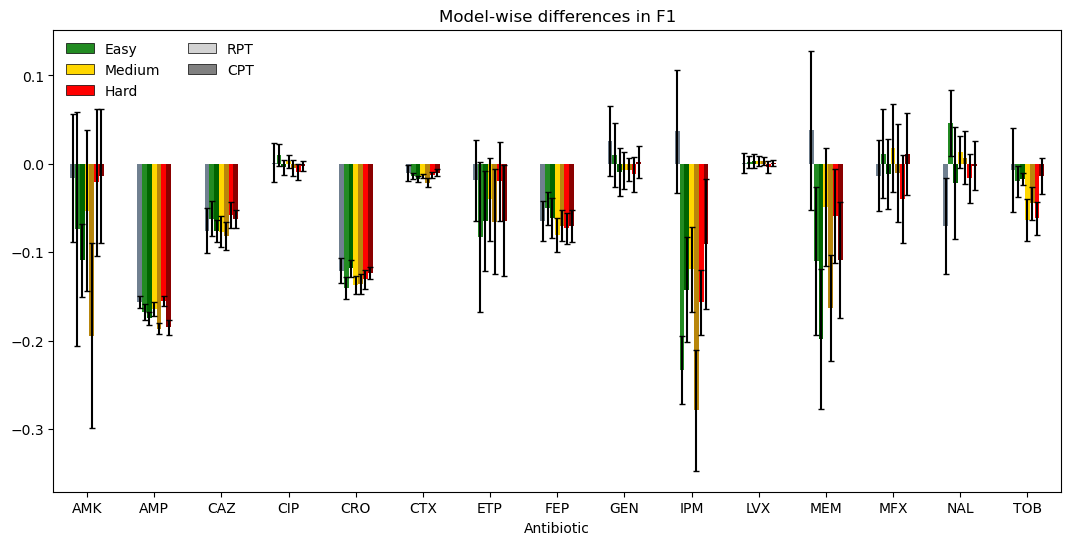

In [21]:
metrics = ['sensitivity', 'specificity', 'precision', 'F1', 'auc_score']
df_diff_ab = calculate_ab_level_differences(df_CV_ab, df_CV_ab_no_bla, metrics=metrics)
plot_ab_level_differences(df_diff_ab, 'F1')

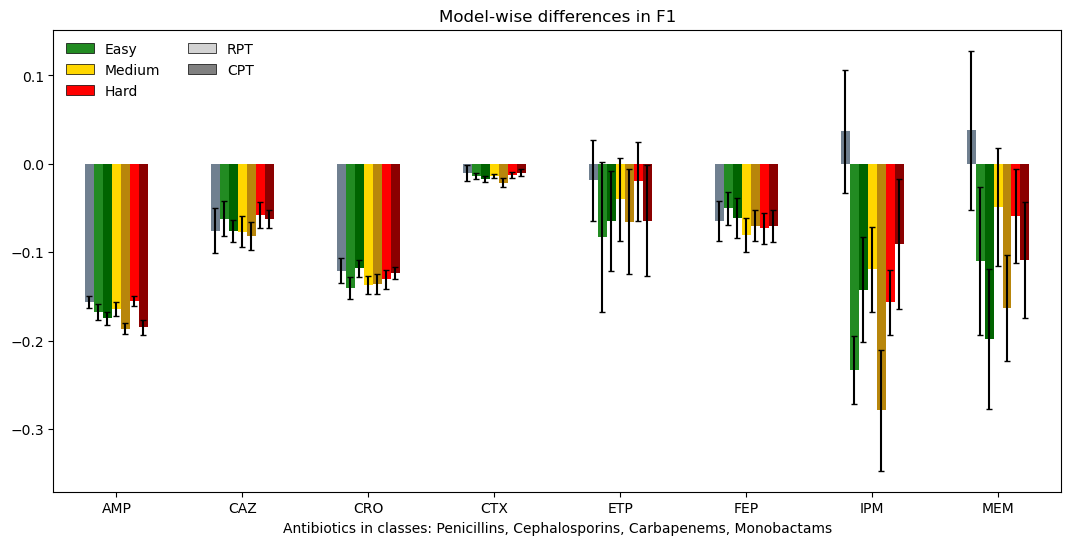

In [22]:
plot_ab_level_differences(df_diff_ab, 'F1', ab_classes=beta_lactams)

In [ ]:
plot_ab_level_differences(df_diff_ab, 'auc_score', ab_classes=beta_lactams)

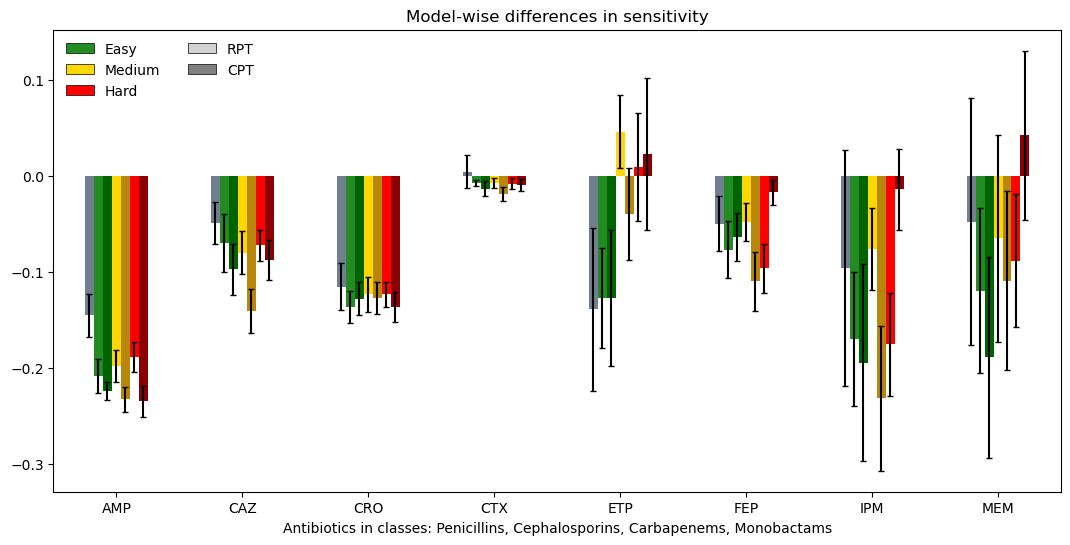

In [23]:
plot_ab_level_differences(df_diff_ab, 'sensitivity', ab_classes=beta_lactams)

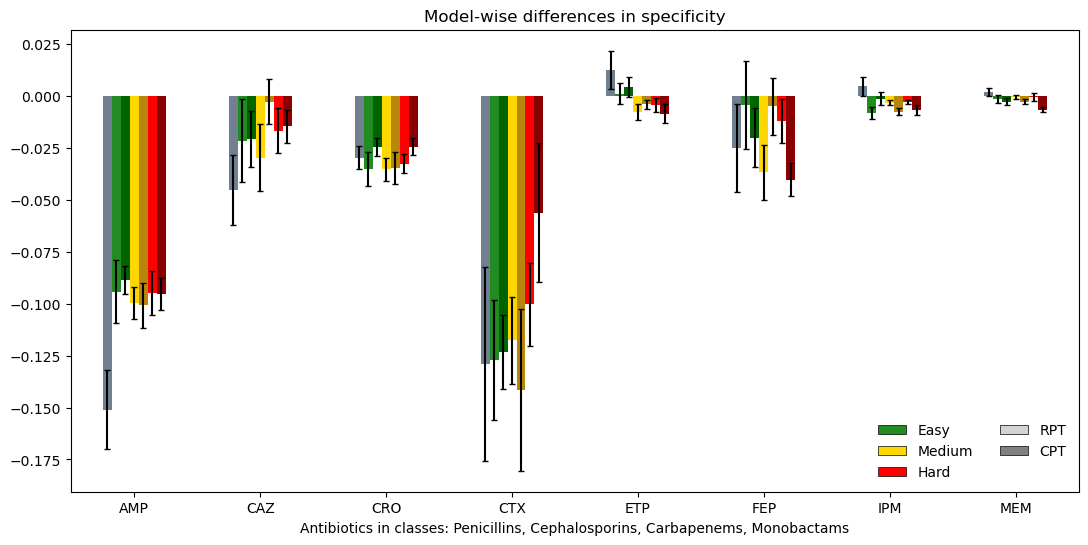

In [24]:
plot_ab_level_differences(df_diff_ab, 'specificity', ab_classes=beta_lactams)

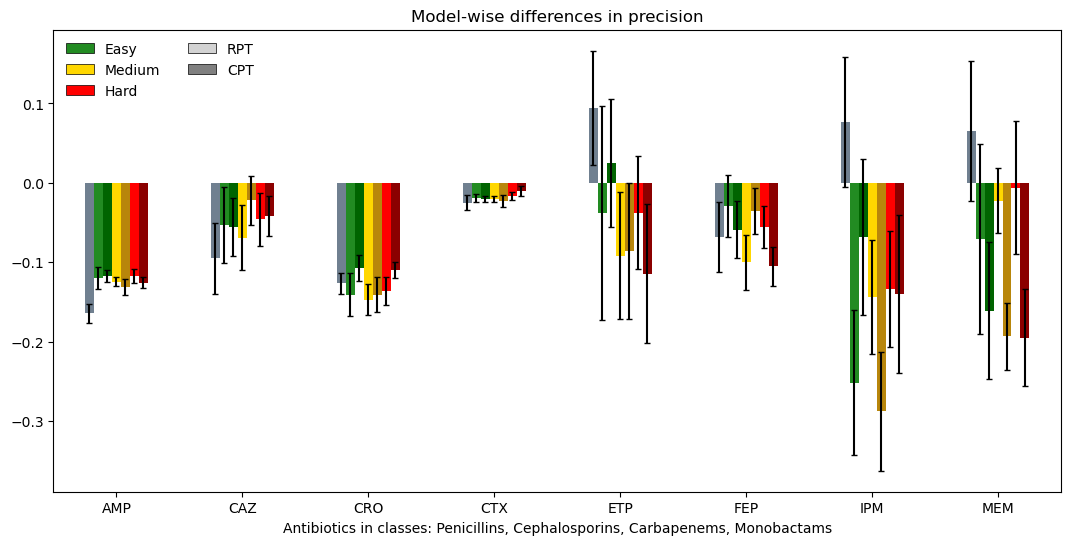

In [25]:
plot_ab_level_differences(df_diff_ab, 'precision', ab_classes=beta_lactams)

#### Relative differences to model without PT for both presence and abscence of *bla* genes

In [26]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs(train_params, model_names=model_names, exp_folder=exp_folder, include_auc=True)
df_CV_no_bla, df_diff_no_bla = load_and_create_abs_and_rel_diff_dfs('no_bla_'+train_params, model_names=model_names, exp_folder=exp_folder, include_auc=True)
# colors = ['slategray', 'forestgreen', 'gold', 'red']
colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
drop_metrics = ['loss', 'accuracy']

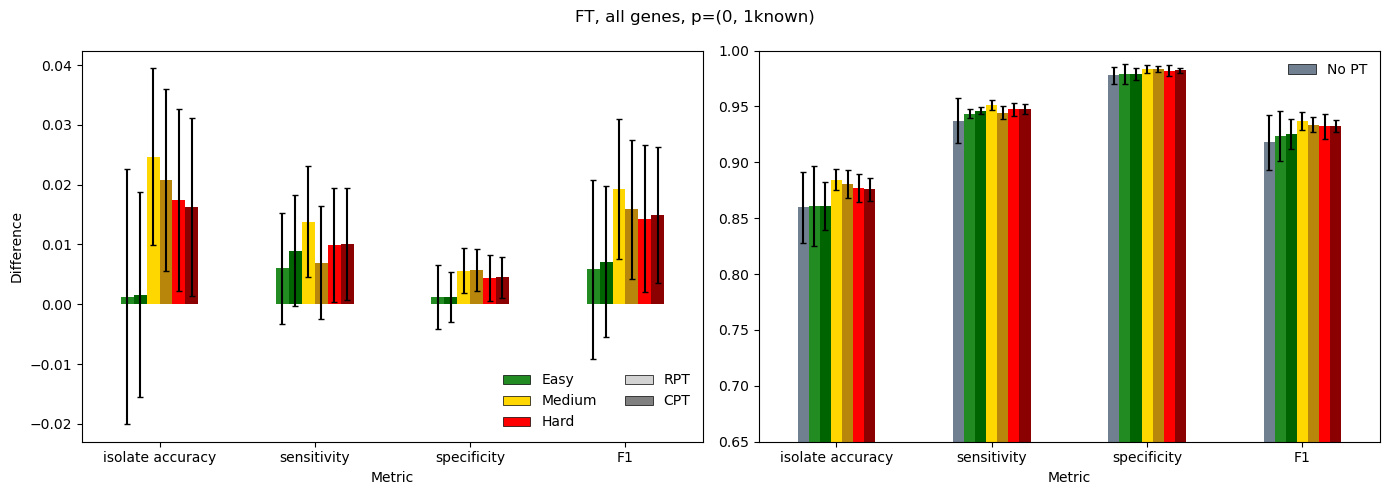

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
rpt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax1.legend(
    handles=[easyPT, mediumPT, hardPT, rpt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'RPT', 'CPT'],
    ncols=2,
    framealpha=0,
)
ax2.legend(
    handles=[noPT],
    labels=['No PT'],
    ncols=1,
    framealpha=0,
)
ax2.set_ylim(0.65, 1)
ax2.set_xlabel('Metric')

fig.suptitle("FT, all genes, p=("+train_params.replace('_', ', ')+")")
fig.tight_layout()

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'FT_diff.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True) if save_results else None
plt.show()

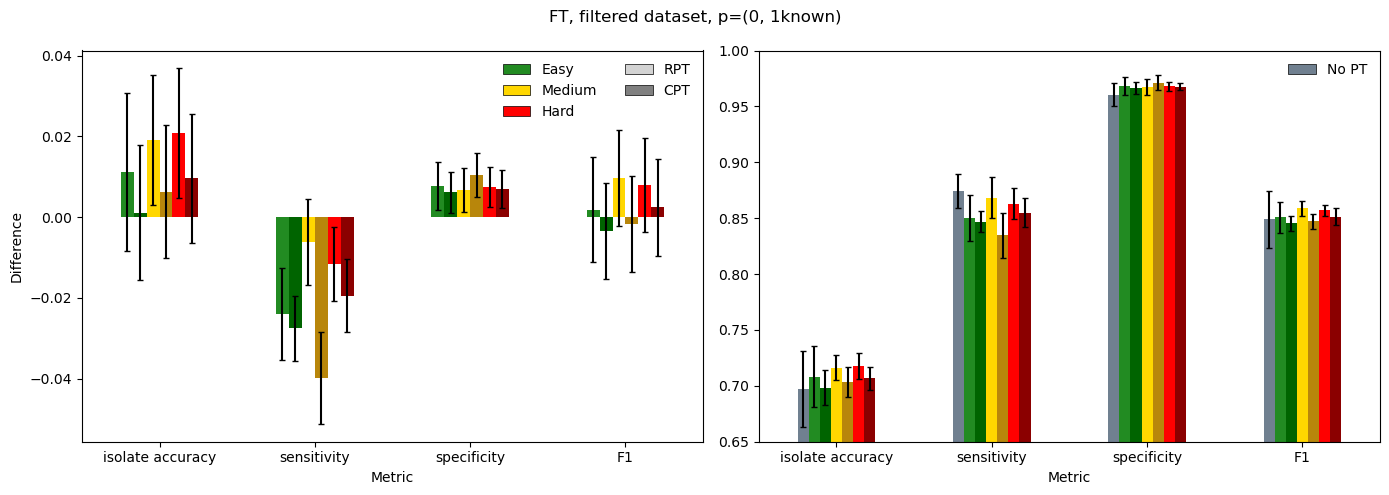

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]  # Select the first subplot
df_diff_no_bla.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV_no_bla.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
rpt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax1.legend(
    handles=[easyPT, mediumPT, hardPT, rpt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'RPT', 'CPT'],
    ncols=2,
    framealpha=0,
)
ax2.legend(
    handles=[noPT],
    labels=['No PT'],
    ncols=1,
    framealpha=0,
)
ax2.set_ylim(0.65, 1)
ax2.set_xlabel('Metric')

fig.suptitle("FT, filtered dataset, p=("+train_params.replace('_', ', ')+")")
fig.tight_layout()

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'FT_diff.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True) if save_results else None
plt.show()

#### Isolate-level

In [29]:
def get_stats_by_group(df, group_col):
    df_stats = df.groupby(group_col).agg({
        'genotypes': 'count',
        'num_genotypes': ['mean', 'std'],
        'num_ab': ['mean', 'std'],
        'num_masked_ab': 'sum',
        'num_correct': 'sum',
        'num_masked_S': 'sum',
        'correct_S': 'sum',
        'num_masked_R': 'sum',
        'correct_R': 'sum',
        'all_correct': 'mean',
    })
    df_stats.rename(columns={'all_correct': 'isolate accuracy'}, inplace=True)
    df_stats['specificity'] = df_stats['correct_S'] / df_stats['num_masked_S']
    df_stats['sensitivity'] = df_stats['correct_R'] / df_stats['num_masked_R']
    df_stats['accuracy'] = df_stats['num_correct'] / df_stats['num_masked_ab']
    df_stats.drop(['num_masked_ab', 'num_correct', 'num_masked_S', 'correct_S', 'num_masked_R', 'correct_R'], axis=1, inplace=True)
    return df_stats

In [30]:
# abbr_to_class = config['data']['antibiotics']['abbr_to_class']
# containing_bla['num_bla_ab_masked'] = containing_bla['masked_ab'].apply(lambda x: len([ab for ab in x if abbr_to_class[ab.split('_')[0]] in beta_lactams]))
# containing_bla['num_R_bla_ab_masked'] = containing_bla['masked_ab'].apply(lambda x: len([ab for ab in x if abbr_to_class[ab.split('_')[0]] in beta_lactams and ab.split('_')[1] == 'R']))
# res_df = get_stats_by_group(containing_bla, 'num_bla_ab_masked')
# res_df

In [31]:
# res_df = get_stats_by_group(containing_bla, 'num_R_bla_ab_masked')
# res_df

### Removing all *bla* genes - all genes vs. MASK-replaced

#### Antibiotic-level

In [32]:
model_names = ['No PT', 'Easy RPT', 'Medium RPT', 'Hard RPT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
exp_folder = '2024-04-19_gene_mask_replace'
train_params = '0_1known'
save_results = False
df_CV_ab = load_and_create_ab_df(train_params, model_names=model_names, exp_folder=exp_folder, include_auc=True)
df_CV_ab_no_bla = load_and_create_ab_df('no_bla_'+train_params, model_names=model_names, exp_folder=exp_folder, include_auc=True)
ab_classes = ['Penicillins', 'Cephalosporins', 'Carbapenems', 'Monobactams']

c:\Users\jespe\Documents\GitHub_local\ARFusion\utils.py:209: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(arr, axis=0)
c:\Users\jespe\miniconda3\envs\ARFusion\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


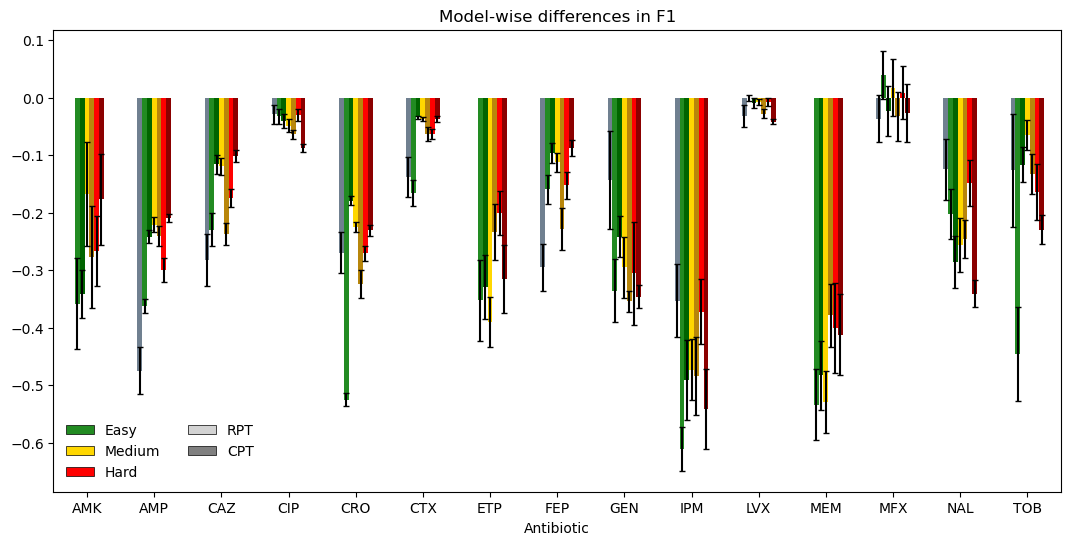

In [33]:
df_diff_ab = calculate_ab_level_differences(df_CV_ab, df_CV_ab_no_bla, include_auc=True)
plot_ab_level_differences(df_diff_ab, 'F1')

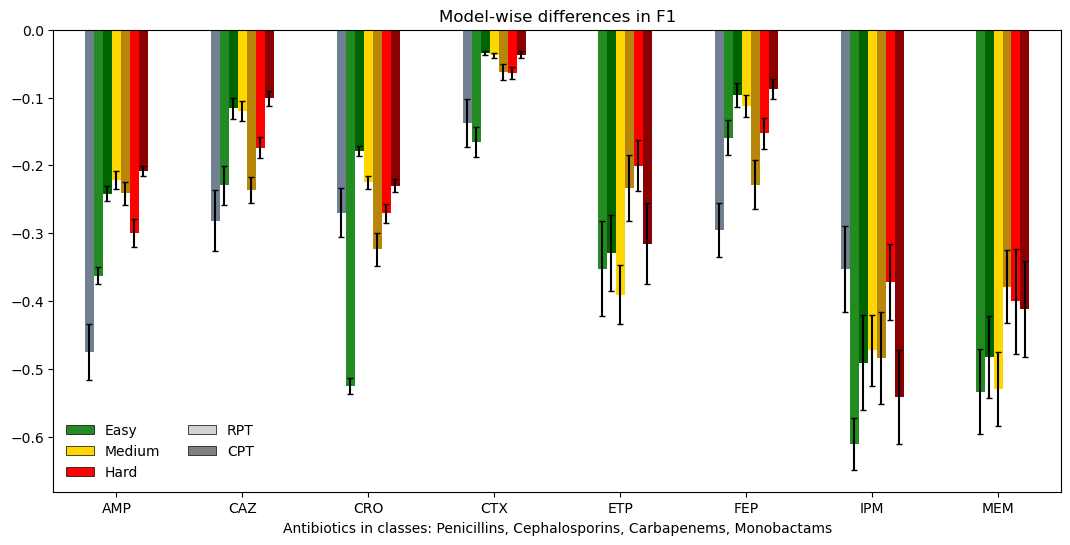

In [34]:
plot_ab_level_differences(df_diff_ab, 'F1', ab_classes=ab_classes)

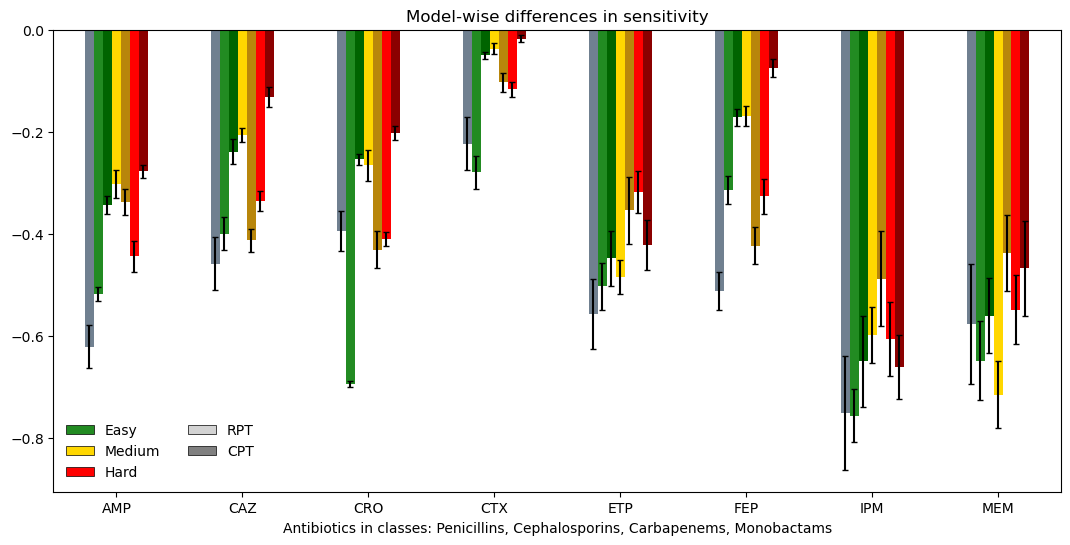

In [35]:
plot_ab_level_differences(df_diff_ab, 'sensitivity', ab_classes=ab_classes)

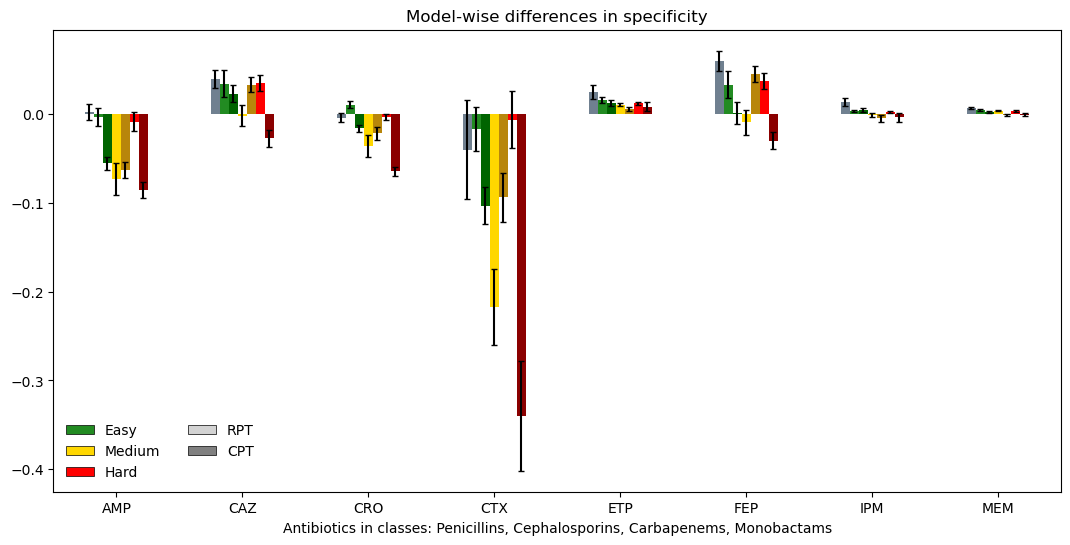

In [36]:
plot_ab_level_differences(df_diff_ab, 'specificity', ab_classes=ab_classes)

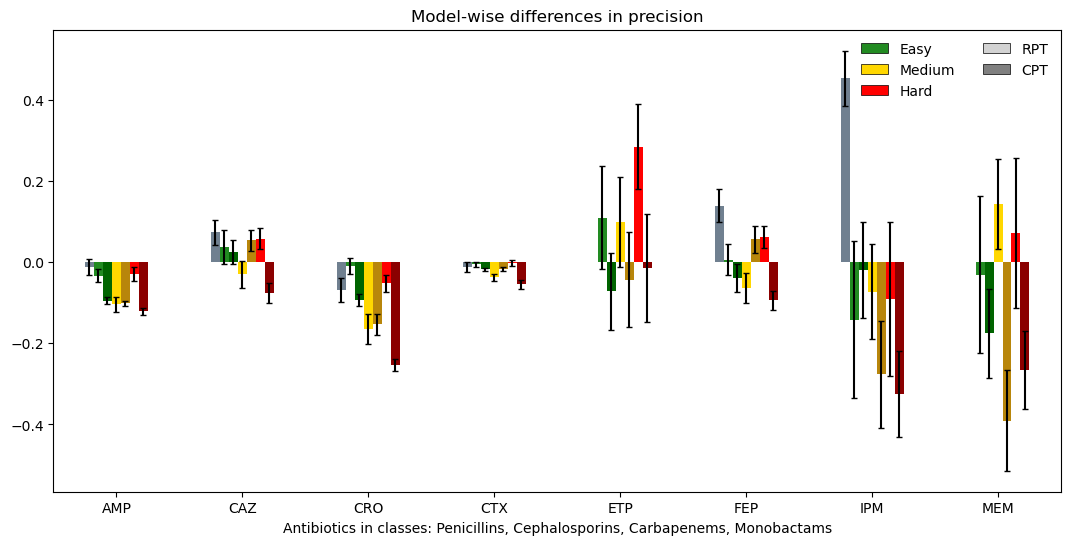

In [37]:
plot_ab_level_differences(df_diff_ab, 'precision', ab_classes=ab_classes)

In [ ]:
plot_ab_level_differences(df_diff_ab, 'auc_score', ab_classes=ab_classes)

#### Relative differences to model without PT for both presence and abscence of *bla* genes

In [38]:
df_CV, df_diff = load_and_create_abs_and_rel_diff_dfs(train_params, model_names=model_names, exp_folder=exp_folder, include_auc=True)
df_CV_no_bla, df_diff_no_bla = load_and_create_abs_and_rel_diff_dfs('no_bla_'+train_params, model_names=model_names, exp_folder=exp_folder, include_auc=True)
# colors = ['slategray', 'forestgreen', 'gold', 'red']
colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
drop_metrics = ['loss', 'accuracy']

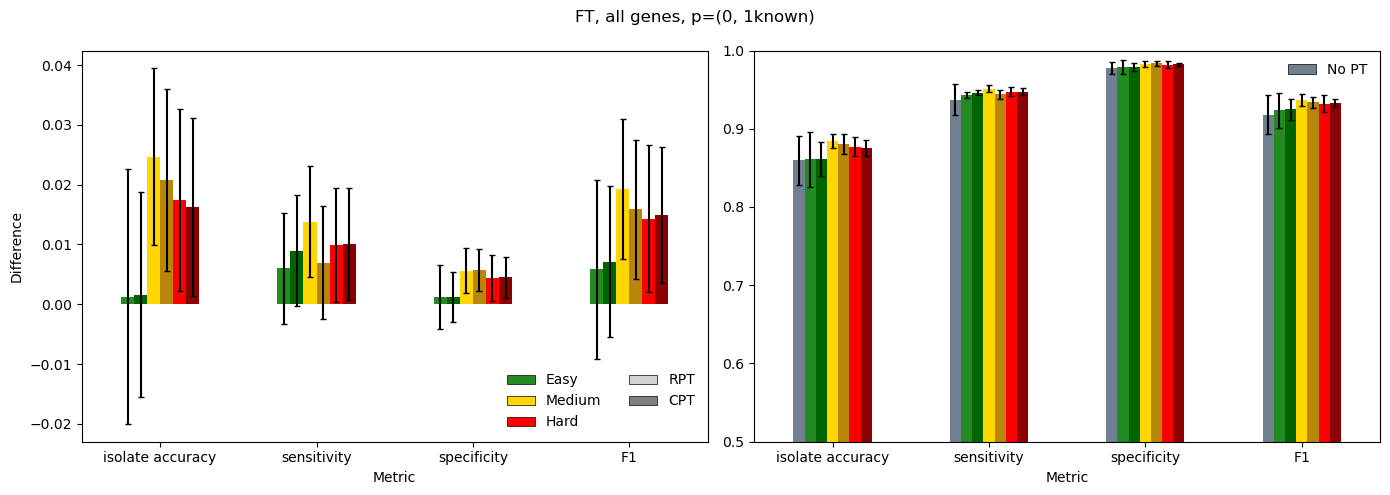

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]  # Select the first subplot
df_diff.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
rpt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax1.legend(
    handles=[easyPT, mediumPT, hardPT, rpt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'RPT', 'CPT'],
    ncols=2,
    framealpha=0,
)
ax2.legend(
    handles=[noPT],
    labels=['No PT'],
    ncols=1,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')

fig.suptitle("FT, all genes, p=("+train_params.replace('_', ', ')+")")
fig.tight_layout()

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rand0.75FT_diff.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True) if save_results else None
plt.show()

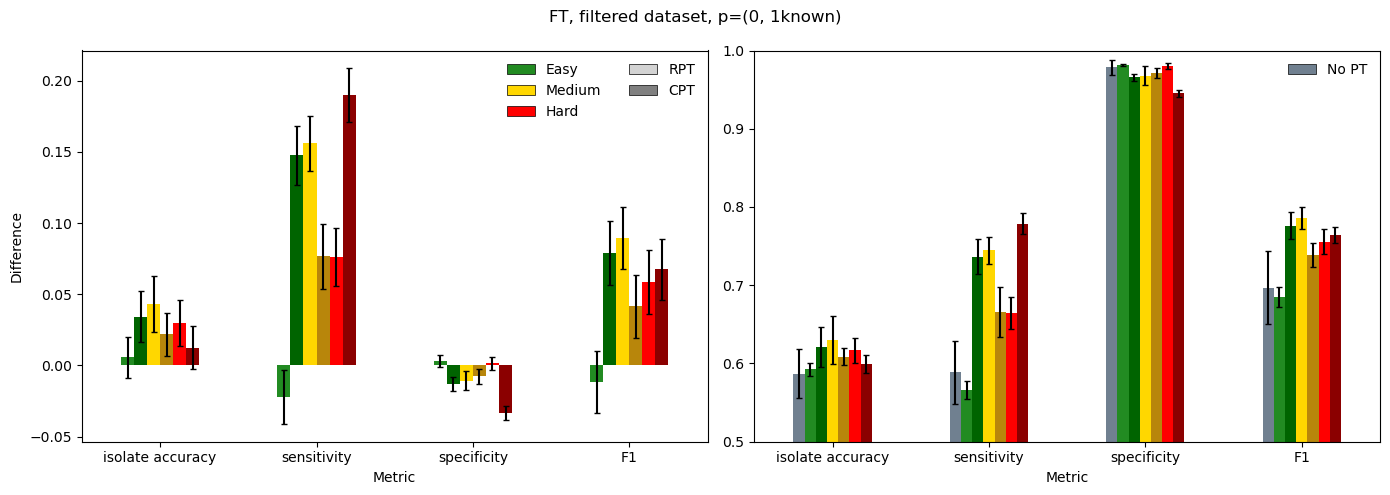

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]  # Select the first subplot
df_diff_no_bla.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV_no_bla.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
rpt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax1.legend(
    handles=[easyPT, mediumPT, hardPT, rpt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'RPT', 'CPT'],
    ncols=2,
    framealpha=0,
)
ax2.legend(
    handles=[noPT],
    labels=['No PT'],
    ncols=1,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')

fig.suptitle("FT, filtered dataset, p=("+train_params.replace('_', ', ')+")")
fig.tight_layout()

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rand0.75FT_diff.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True) if save_results else None
plt.show()

### Removing all *bla* genes - pad-replaced vs. mask-replaced

In [41]:
model_names = ['No PT', 'Easy RPT', 'Medium RPT', 'Hard RPT', 'Easy CPT', 'Medium CPT', 'Hard CPT']
exp_folder_pad = '2024-04-19_gene_pad_replace'
exp_folder_mask = '2024-04-19_gene_mask_replace'
save_results = False
train_params = '0_1known'
df_CV_ab_pad = load_and_create_ab_df('no_bla_'+train_params, model_names=model_names, exp_folder=exp_folder_pad, include_auc=True)
df_CV_ab_mask = load_and_create_ab_df('no_bla_'+train_params, model_names=model_names, exp_folder=exp_folder_mask, include_auc=True)
ab_classes = ['Penicillins', 'Cephalosporins', 'Carbapenems', 'Monobactams']

c:\Users\jespe\Documents\GitHub_local\ARFusion\utils.py:209: RuntimeWarning: Mean of empty slice
  avg = np.nanmean(arr, axis=0)
c:\Users\jespe\miniconda3\envs\ARFusion\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


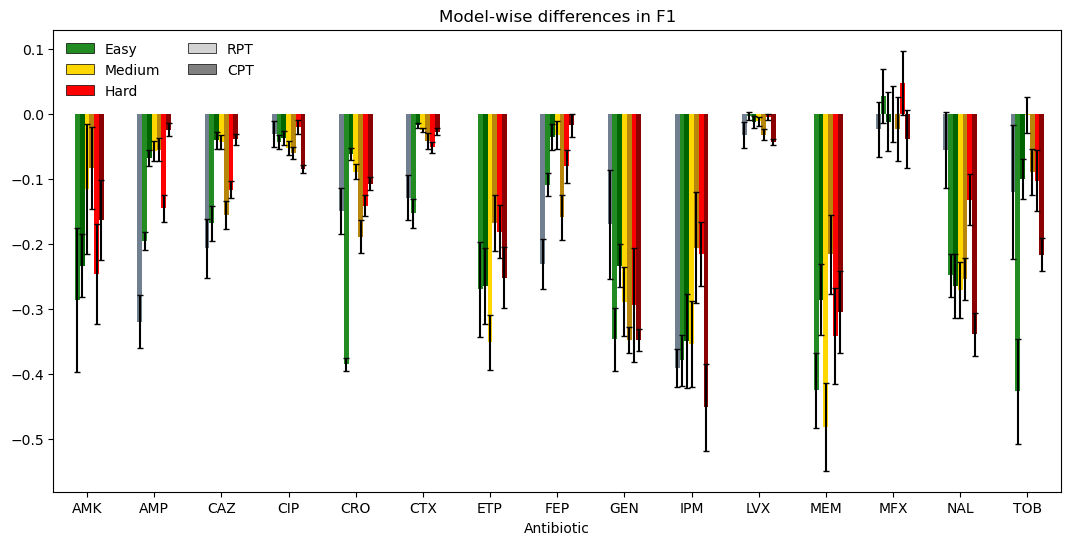

In [42]:
df_diff_ab = calculate_ab_level_differences(df_CV_ab_pad, df_CV_ab_mask, include_auc=True)
plot_ab_level_differences(df_diff_ab, 'F1')

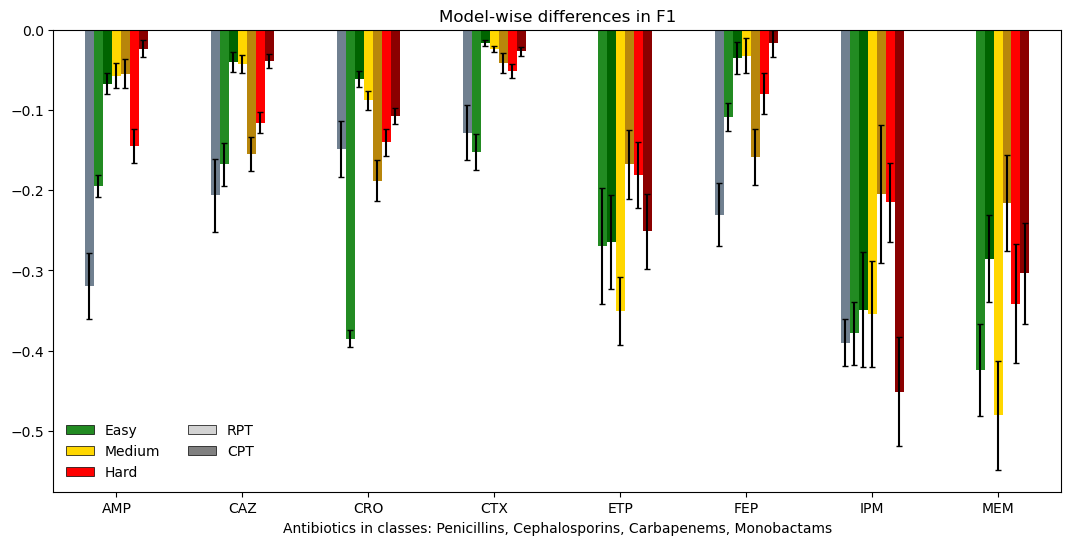

In [43]:
plot_ab_level_differences(df_diff_ab, 'F1', ab_classes=ab_classes)

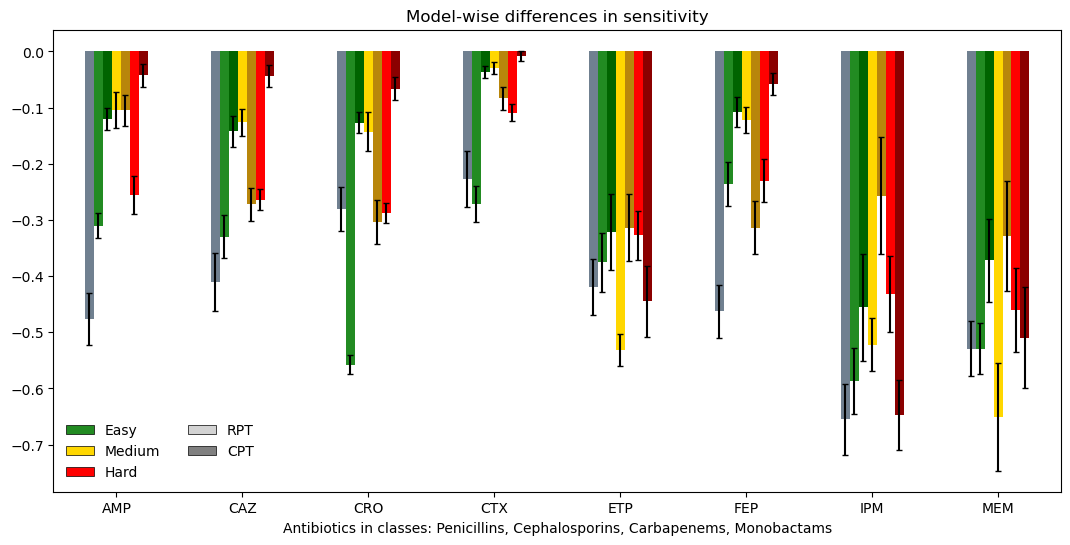

In [44]:
plot_ab_level_differences(df_diff_ab, 'sensitivity', ab_classes=ab_classes)

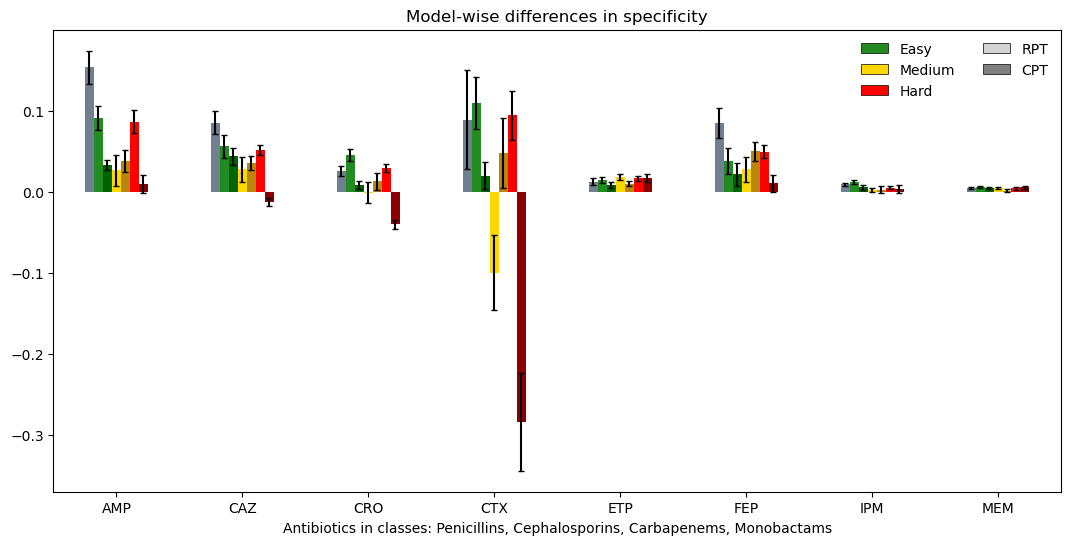

In [45]:
plot_ab_level_differences(df_diff_ab, 'specificity', ab_classes=ab_classes)

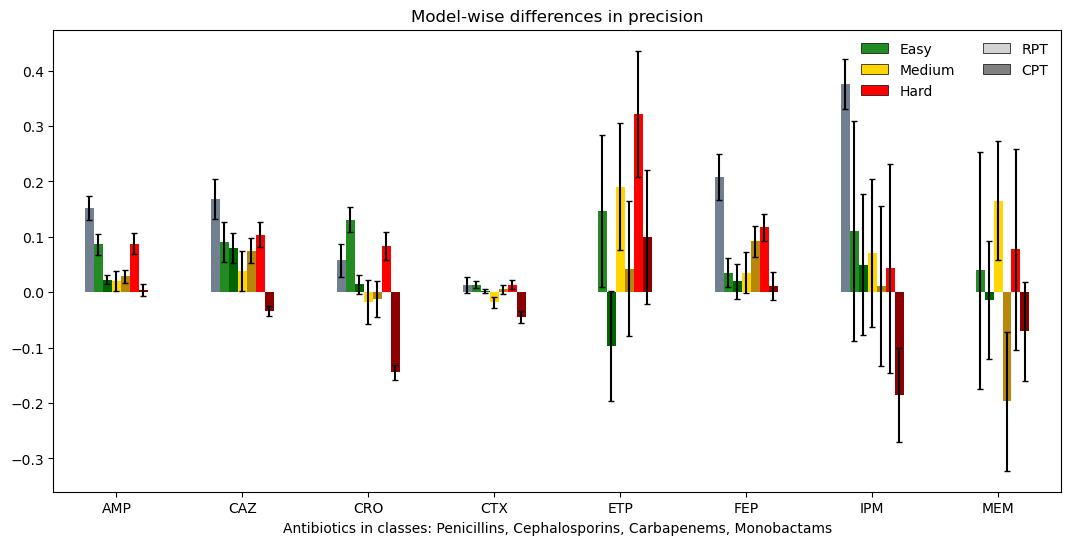

In [46]:
plot_ab_level_differences(df_diff_ab, 'precision', ab_classes=ab_classes)

In [ ]:
plot_ab_level_differences(df_diff_ab, 'auc_score', ab_classes=ab_classes)

In [47]:
df_CV_pad, df_diff_pad = load_and_create_abs_and_rel_diff_dfs('no_bla_'+train_params, model_names=model_names, exp_folder=exp_folder_pad, include_auc=True)
df_CV_mask, df_diff_mask = load_and_create_abs_and_rel_diff_dfs('no_bla_'+train_params, model_names=model_names, exp_folder=exp_folder_mask, include_auc=True)
colors = ['slategray', 'forestgreen', 'darkgreen', 'gold', 'darkgoldenrod', 'red', 'darkred']
drop_metrics = ['loss', 'accuracy']

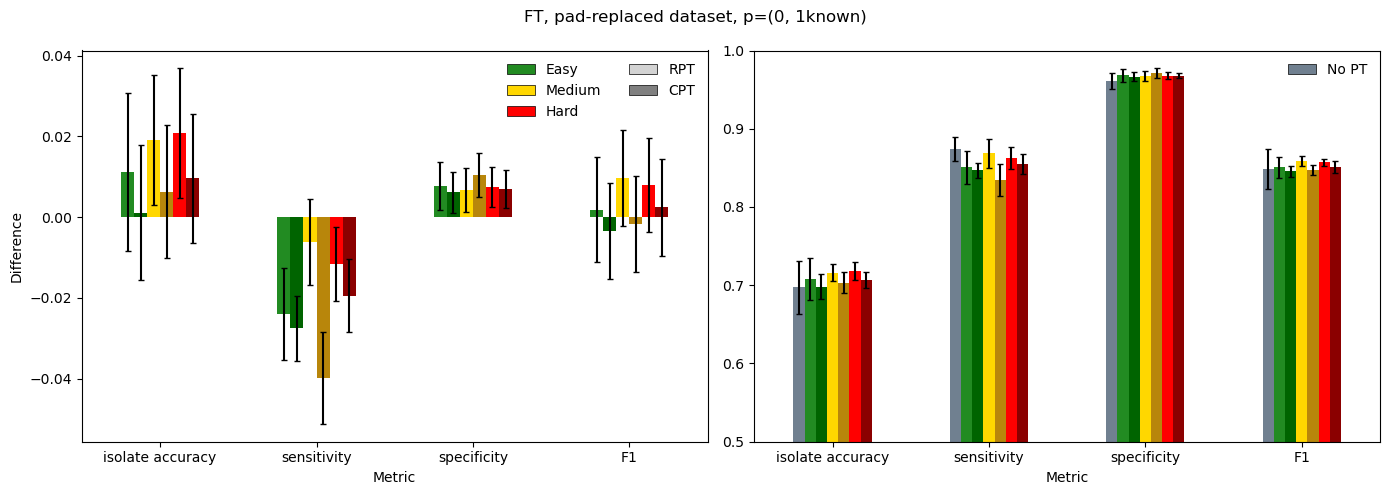

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]  # Select the first subplot
df_diff_pad.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV_pad.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
rpt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax1.legend(
    handles=[easyPT, mediumPT, hardPT, rpt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'RPT', 'CPT'],
    ncols=2,
    framealpha=0,
)
ax2.legend(
    handles=[noPT],
    labels=['No PT'],
    ncols=1,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')

fig.suptitle("FT, pad-replaced dataset, p=("+train_params.replace('_', ', ')+")")
fig.tight_layout()

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rand0.75FT_diff.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True) if save_results else None
plt.show()

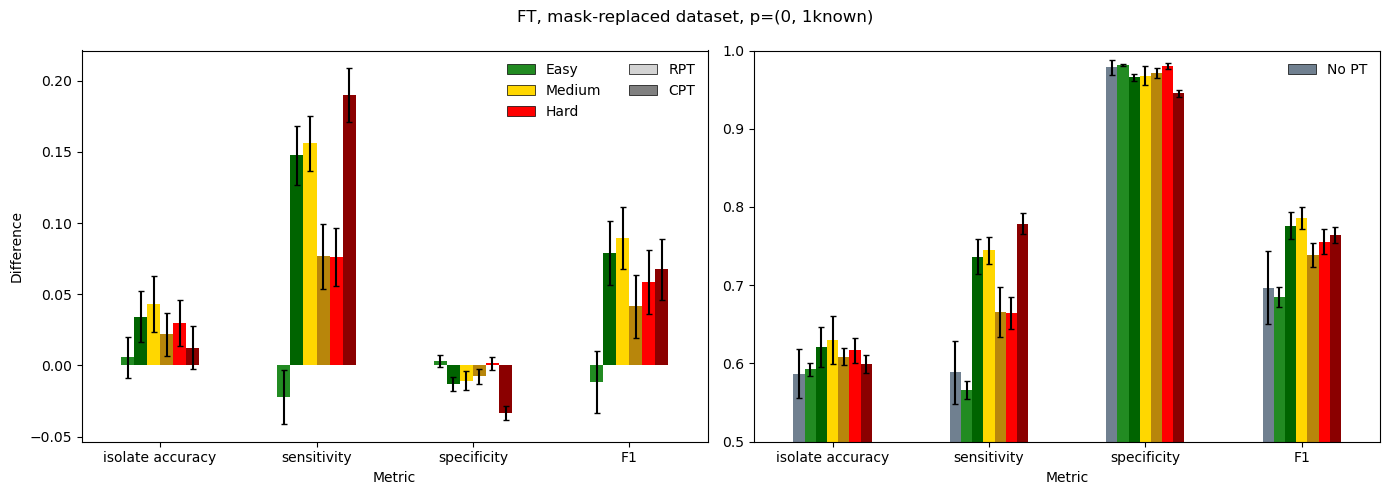

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]  # Select the first subplot
df_diff_mask.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax1, legend=False, capsize=2, ecolor='k', color=colors[1:])
ax1.set_xlabel('Metric')
ax1.set_ylabel('Difference')

ax2 = axes[1]  # Select the second subplot
df_CV_mask.drop(drop_metrics).plot(kind='bar', y='avg', yerr='std', rot=0, ax=ax2, capsize=2, ecolor='k', color=colors)
noPT = Rectangle((0,0),1,1,fc='slategray', edgecolor='k', linewidth=0.5)
easyPT = Rectangle((0,0),1,1,fc='forestgreen', edgecolor='k', linewidth=0.5)
mediumPT = Rectangle((0,0),1,1,fc='gold', edgecolor='k', linewidth=0.5)
hardPT = Rectangle((0,0),1,1,fc='red', edgecolor='k', linewidth=0.5)
rpt = Rectangle((0,0),1,1,fc='lightgrey', edgecolor='k', linewidth=0.5)
cpt = Rectangle((0,0),1,1,fc='grey', edgecolor='k', linewidth=0.5)
ax1.legend(
    handles=[easyPT, mediumPT, hardPT, rpt, cpt],
    labels=['Easy', 'Medium', 'Hard', 'RPT', 'CPT'],
    ncols=2,
    framealpha=0,
)
ax2.legend(
    handles=[noPT],
    labels=['No PT'],
    ncols=1,
    framealpha=0,
)
ax2.set_ylim(0.5, 1)
ax2.set_xlabel('Metric')

fig.suptitle("FT, mask-replaced dataset, p=("+train_params.replace('_', ', ')+")")
fig.tight_layout()

savepath = os.path.join(BASE_DIR, 'results', 'figures', 'M_02_28', 'rand0.75FT_diff.png')
plt.savefig(savepath, bbox_inches='tight', dpi=300, transparent=True) if save_results else None
plt.show()